# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [57]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [58]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [59]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [60]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

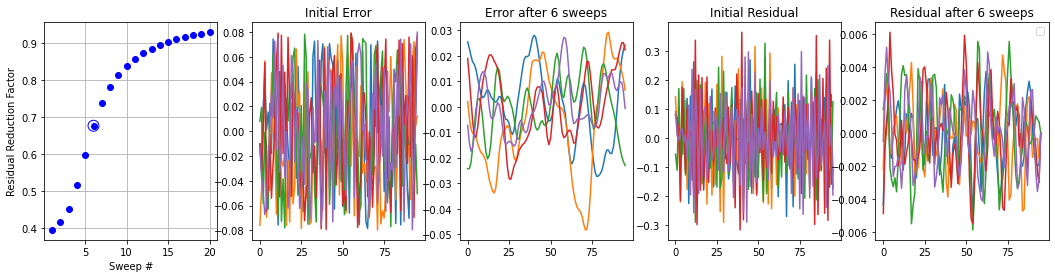

In [61]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

Moviepy - Building video laplace_shrinkage.mp4.
Moviepy - Writing video laplace_shrinkage.mp4



Moviepy - Done !
Moviepy - video ready laplace_shrinkage.mp4


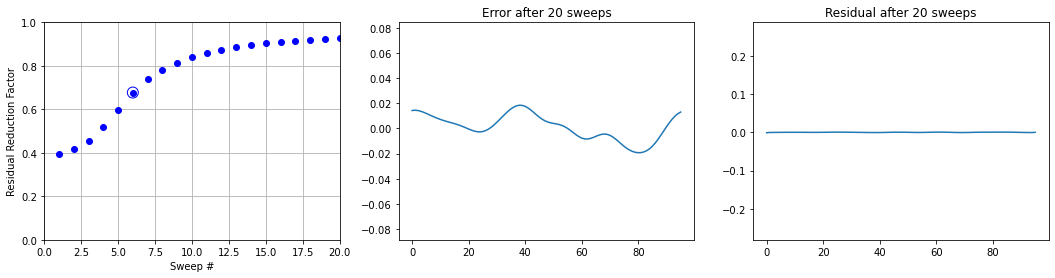

In [62]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [65]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
print("kh", kh)

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

kh 0.5233853805513015


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     4.155e-01 (0.336) [0.336]    3.068e-01    1.361 (0.490)
INFO     2     1.837e-01 (0.443) [0.386]    2.704e-01    0.684 (0.503)
INFO     3     1.149e-01 (0.625) [0.453]    2.542e-01    0.454 (0.665)
INFO     4     8.925e-02 (0.775) [0.519]    2.437e-01    0.368 (0.809)
INFO     5     7.628e-02 (0.853) [0.573]    2.355e-01    0.325 (0.882)
INFO     6     6.815e-02 (0.892) [0.617]    2.286e-01    0.298 (0.919)
INFO     7     6.238e-02 (0.915) [0.653]    2.226e-01    0.280 (0.940)
INFO     8     5.798e-02 (0.929) [0.682]    2.173e-01    0.267 (0.952)
INFO     9     5.443e-02 (0.939) [0.707]    2.124e-01    0.256 (0.961)
INFO     10    5.147e-02 (0.946) [0.728]    2.080e-01    0.248 (0.966)
INFO     11    4.892e-02 (0.951) [0.746]    2.038e-01    0.240 (0.970)
INFO     Relax conv 0.95 shrinkage 0.39 PODR RER 0.68 after 2 sweeps. Work 1

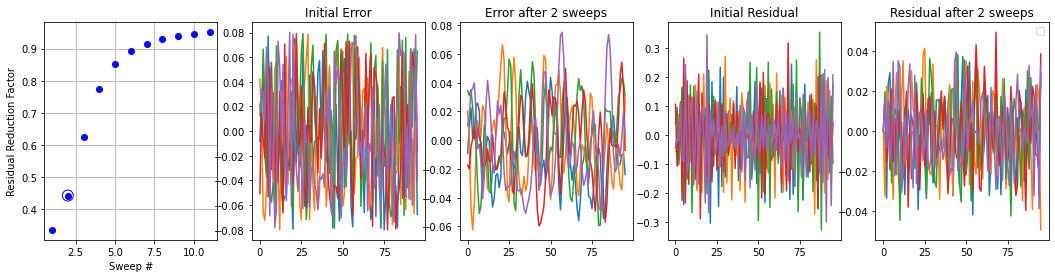

In [67]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

Moviepy - Building video kaczmarz_shrinkage.mp4.
Moviepy - Writing video kaczmarz_shrinkage.mp4



Moviepy - Done !
Moviepy - video ready kaczmarz_shrinkage.mp4


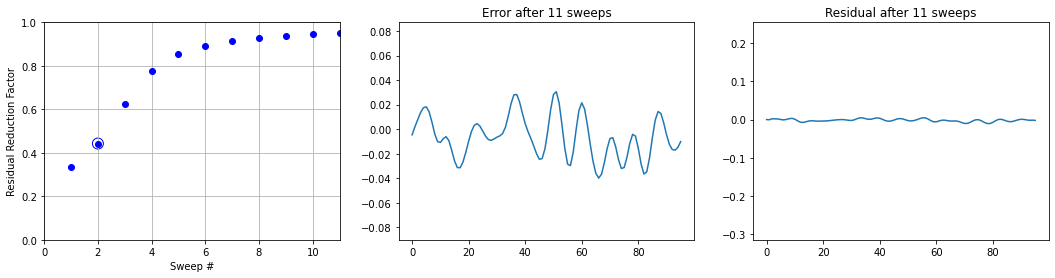

In [68]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
animation.write_videofile("kaczmarz_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [50]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.122


### Coarsening: Fixed (4/2)

In [8]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,0.5038,0.5023,0.4992,0.4946
1,0.6702,0.2178,-0.2307,-0.6710


nu 100 s [1.    0.058 0.002 0.   ] Energy error [0.058 0.002 0.    0.   ]
INFO     Mock cycle conv [0.331 0.114 0.106 0.024 0.01  0.011 0.006 0.005 0.005 0.004 0.003]


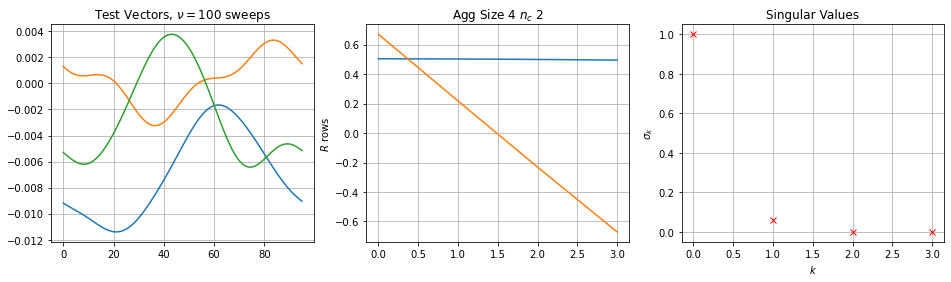

In [9]:
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.4790,-0.5230,-0.5203,-0.4757,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.6679,-0.2309,0.2377,0.6664,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4790,-0.5230,-0.5203,-0.4757,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.6679,-0.2309,0.2377,0.6664,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4790,-0.5230


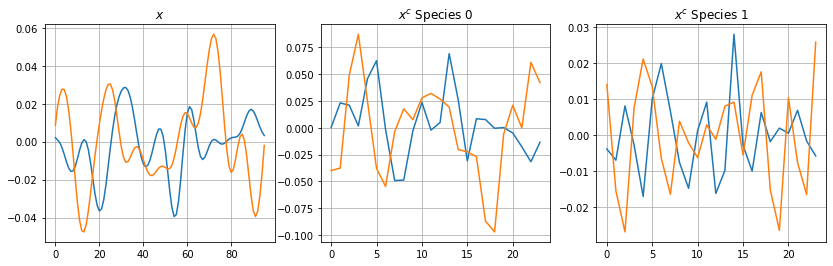

In [10]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [11]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.342 0.111 0.068 0.027 0.015 0.01 ]


### Interpolation $P = R^T$

In [12]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 3.12


### Interpolation by LS Fitting

In [13]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6
Mock,nan,nan,nan,nan,nan,0.34,0.11,0.07,0.03,0.01,0.01
P=R^T,nan,nan,nan,nan,nan,0.54,0.45,0.38,0.33,0.29,0.26
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.64,0.55,0.48,0.45,0.43,0.42
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.49,0.35,0.27,0.22,0.18,0.16
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.48,0.23,0.11,0.07,0.05,0.04
R A P caliber 2,1.00,2.00,192.00,1.20,0.00,0.71,0.58,0.51,0.48,0.47,0.46
R A P caliber 3,1.00,3.00,288.00,1.20,0.00,0.54,0.39,0.31,0.25,0.23,0.21
R A P caliber 4,1.00,4.00,384.00,1.20,0.00,0.52,0.29,0.20,0.14,0.12,0.10


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [14]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.4816,-0.6717
1,-0.5190,-0.2187
2,-0.5169,0.2299
3,-0.4781,0.6651


A^1


,0,1,2,3,4,5
0,-0.5345,-0.0082,0.2656,0.3905,0.2656,-0.3891
1,-0.0082,-1.7701,-0.3891,-0.5707,0.3905,-0.5707


caliber 3 P


,0,1,2,3
0,-0.4663,-0.5758,0.0000,-0.0339
1,-0.5356,-0.3206,0.0000,0.0339
2,-0.5352,0.3250,0.0351,0.0000
3,-0.4603,0.5717,-0.0371,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.4340,-0.0053,0.2152,0.2962,0.0018,0.0018,0.2152,-0.2965
1,-0.0053,-1.3951,-0.2965,-0.4080,0.0000,0.0000,0.2962,-0.4080


caliber 4 P


,0,1,2,3,4,5
0,-0.3813,-0.4119,0.0000,0.0000,-0.1169,0.1673
1,-0.5996,-0.4444,0.0000,0.0000,0.0964,-0.1257
2,-0.5942,0.4376,0.0930,0.1246,0.0000,0.0000
3,-0.3853,0.4286,-0.1105,-0.1583,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.3672,-0.0038,0.1698,0.2547,0.0138,0.0185,0.0138,-0.0180,0.1698,-0.2553
1,-0.0038,-1.2854,-0.2553,-0.3789,-0.0180,-0.0243,0.0185,-0.0243,0.2547,-0.3789


R*A*P
caliber 2 P


,0,1
0,-0.4816,-0.6717
1,-0.5190,-0.2187
2,-0.5169,0.2299
3,-0.4781,0.6651


A^1


,0,1,2,3,4,5
0,-0.5318,-0.0077,0.2640,0.3883,0.2639,-0.3866
1,-0.0054,-1.7649,-0.3896,-0.5714,0.3878,-0.5667


caliber 3 P


,0,1,2,3
0,-0.4663,-0.5758,0.0000,-0.0339
1,-0.5356,-0.3206,0.0000,0.0339
2,-0.5352,0.3250,0.0351,0.0000
3,-0.4603,0.5717,-0.0371,0.0000


A^1


,0,1,2,3,4,5
0,-0.4696,-0.0066,0.2347,0.3275,0.2347,-0.3272
1,-0.0055,-1.5026,-0.3246,-0.4824,0.3240,-0.4800


caliber 4 P


,0,1,2,3,4,5
0,-0.3813,-0.4119,0.0000,0.0000,-0.1169,0.1673
1,-0.5996,-0.4444,0.0000,0.0000,0.0964,-0.1257
2,-0.5942,0.4376,0.0930,0.1246,0.0000,0.0000
3,-0.3853,0.4286,-0.1105,-0.1583,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.2868,-0.0001,0.1428,0.1415,0.1435,-0.1485
1,0.0014,-0.7841,-0.1470,-0.1173,0.1408,-0.1180


In [15]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.860e+01 RER 3.42343
INFO         1 |r| 1.689e+00 (0.09083) RER 0.08710 (0.02544) 19.395
INFO         2 |r| 9.395e-02 (0.05562) RER 0.00487 (0.05593) 19.285
INFO         3 |r| 1.009e-02 (0.10740) RER 0.00052 (0.10741) 19.284
INFO         4 |r| 1.818e-03 (0.18012) RER 0.00009 (0.18011) 19.285
INFO         5 |r| 3.465e-04 (0.19066) RER 0.00002 (0.19066) 19.285
INFO         6 |r| 6.785e-05 (0.19580) RER 0.00000 (0.19580) 19.285
INFO         7 |r| 1.331e-05 (0.19610) RER 0.00000 (0.19610) 19.285
INFO         8 |r| 2.614e-06 (0.19644) RER 0.00000 (0.19644) 19.285
INFO         9 |r| 5.134e-07 (0.19643) RER 0.00000 (0.19643) 19.285
INFO        10 |r| 1.008e-07 (0.19643) RER 0.00000 (0.19643) 19.285
INFO        11 |r| 1.981e-08 (0.19640) RER 0.00000 (0.19640) 19.285
INFO        12 |r| 3.890e-09 (0.19639) RER 0.00000 (0.19639) 19.285
INFO        13 |r| 7.639e-10 (0.19639) RER 0.00000 (0.19639) 19.285
INFO        14 |r| 1.500e-10 (0.19639) RER 0.00000 (0.19639) 19.285
INFO   

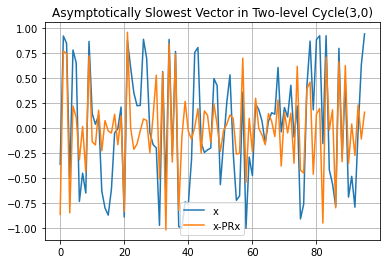

In [16]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [17]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.    -0.004 -0.004 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]
1 lam [-0.001 -0.005 -0.005 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]


In [18]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [19]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,-0.2868,-0.0001,0.1428,0.1415,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0014,-0.7841,-0.1470,-0.1173,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.1435,-0.1485,-0.2868,-0.0001,0.1428,0.1415,0.0000,0.0000,0.0000,0.0000
3,0.1408,-0.1180,0.0014,-0.7841,-0.1470,-0.1173,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.1435,-0.1485,-0.2868,-0.0001,0.1428,0.1415,0.0000,0.0000
5,0.0000,0.0000,0.1408,-0.1180,0.0014,-0.7841,-0.1470,-0.1173,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.1435,-0.1485,-0.2868,-0.0001,0.1428,0.1415
7,0.0000,0.0000,0.0000,0.0000,0.1408,-0.1180,0.0014,-0.7841,-0.1470,-0.1173
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1435,-0.1485,-0.2868,-0.0001
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1408,-0.1180,0.0014,-0.7841


In [20]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0014,-0.0007,0.0007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0014,0.0000,0.0015,0.0007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0007,-0.0015,0.0000,-0.0014,-0.0007,0.0007,0.0000,0.0000,0.0000,0.0000
3,-0.0007,-0.0007,0.0014,0.0000,0.0015,0.0007,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0007,-0.0015,0.0000,-0.0014,-0.0007,0.0007,0.0000,0.0000
5,0.0000,0.0000,-0.0007,-0.0007,0.0014,0.0000,0.0015,0.0007,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0007,-0.0015,0.0000,-0.0014,-0.0007,0.0007
7,0.0000,0.0000,0.0000,0.0000,-0.0007,-0.0007,0.0014,0.0000,0.0015,0.0007
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,-0.0015,0.0000,-0.0014
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0007,-0.0007,0.0014,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [21]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [22]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.830e-01                    4.461e-01    0.637
INFO     1     5.616e-02 (0.199) [0.199]    2.617e-01    0.217 (0.341)
INFO     2     3.450e-02 (0.615) [0.350]    2.375e-01    0.149 (0.682)
INFO     3     2.438e-02 (0.707) [0.442]    2.251e-01    0.113 (0.750)
INFO     4     1.942e-02 (0.797) [0.512]    2.171e-01    0.094 (0.830)
INFO     5     1.668e-02 (0.859) [0.568]    2.112e-01    0.084 (0.887)
INFO     6     1.491e-02 (0.894) [0.613]    2.064e-01    0.077 (0.918)
INFO     7     1.362e-02 (0.913) [0.649]    2.023e-01    0.073 (0.935)
INFO     8     1.262e-02 (0.925) [0.678]    1.988e-01    0.069 (0.945)
INFO     9     1.179e-02 (0.934) [0.703]    1.957e-01    0.065 (0.952)
INFO     10    1.109e-02 (0.940) [0.723]    1.929e-01    0.063 (0.956)
INFO     11    1.049e-02 (0.945) [0.741]    1.903e-01    0.060 (0.960)
INFO     12    9.969e-03 (0.949) [0.757]    1.880e-01    0.058 (0.963)
INFO 

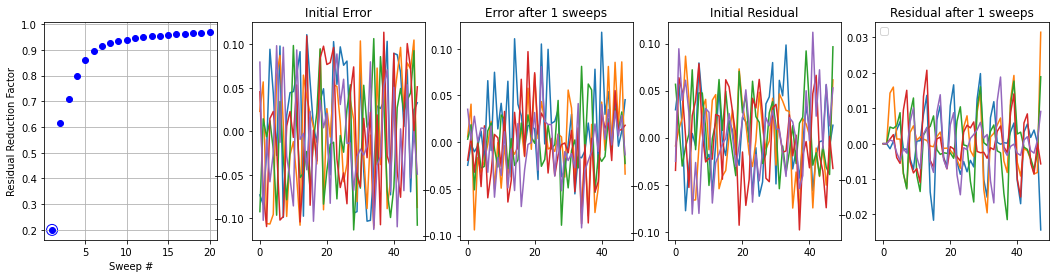

In [23]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,0.7067,-0.0070,0.7073,0.0138
1,-0.6129,-0.3588,0.6156,-0.3415


nu 100 s [1.    0.184 0.023 0.001] Energy error [0.182 0.023 0.001 0.   ]
INFO     Mock cycle conv [0.442 0.232 0.155 0.108 0.088 0.072 0.058 0.049 0.035 0.032 0.025]


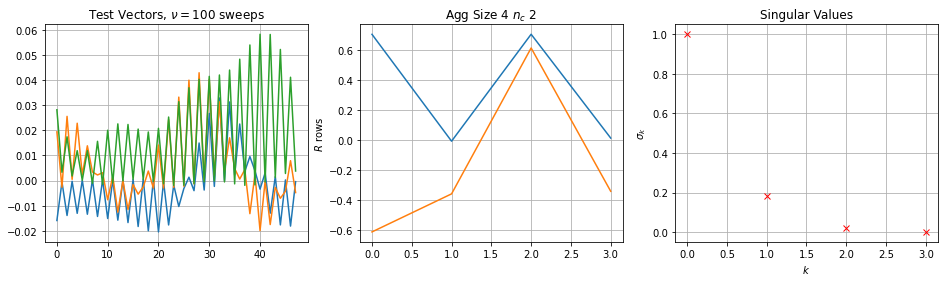

In [24]:

# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [25]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1435,-0.1485,-0.2868,-0.0001,0.1428,0.1415
1,0.1408,-0.1180,0.0014,-0.7841,-0.1470,-0.1173


In [26]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.018


In [27]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [28]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [29]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.176 0.021 0.002]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,0.7022,-0.0100,0.7118,0.0116,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6181,0.3568,-0.6103,0.3437,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.7022,-0.0100,0.7118,0.0116,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6181,0.3568,-0.6103,0.3437,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7022,-0.0100


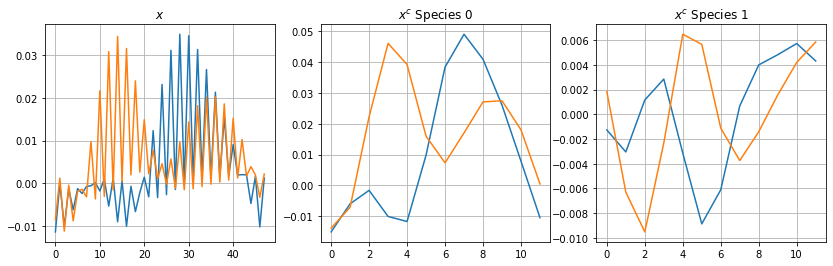

In [30]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [31]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.441 0.238 0.146 0.109 0.095 0.078 0.062 0.051 0.037 0.032 0.028]


In [32]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [33]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.71


### Interpolation by LS Fitting

In [34]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.44,0.24,0.15,0.11,0.10,0.08,0.06,0.05,0.04,0.03,0.03
P=R^T,nan,nan,nan,nan,nan,0.59,0.45,0.37,0.29,0.29,0.28,0.28,0.28,0.28,0.28,0.28
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,0.61,0.47,0.36,0.31,0.25,0.20,0.17,0.14,0.11,0.10,0.10
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.00,0.52,0.33,0.22,0.17,0.13,0.09,0.07,0.08,0.07,0.06,0.06
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,0.26,0.17,0.12,0.10,0.08,0.04,0.06,0.05,0.04,0.04,0.04
R A P caliber 2,1.00,2.00,96.00,1.00,0.01,0.56,0.46,0.36,0.30,0.24,0.19,0.16,0.11,0.11,0.10,0.09
R A P caliber 3,1.00,3.00,144.00,1.00,0.01,0.54,0.36,0.30,0.21,0.20,0.16,0.13,0.10,0.08,0.06,0.05
R A P caliber 4,1.00,4.00,192.00,1.00,0.01,0.44,0.22,0.12,0.08,0.04,0.04,0.04,0.03,0.03,0.03,0.03


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 4.065e+00 RER 0.93521
INFO         1 |r| 2.670e-01 (0.06570) RER 0.06957 (0.07439) 3.839
INFO         2 |r| 2.122e-02 (0.07945) RER 0.00550 (0.07909) 3.856
INFO         3 |r| 4.807e-03 (0.22656) RER 0.00125 (0.22722) 3.845
INFO         4 |r| 1.026e-03 (0.21347) RER 0.00027 (0.21363) 3.842
INFO         5 |r| 2.256e-04 (0.21988) RER 0.00006 (0.21991) 3.842
INFO         6 |r| 4.919e-05 (0.21803) RER 0.00001 (0.21804) 3.842
INFO         7 |r| 1.076e-05 (0.21863) RER 0.00000 (0.21864) 3.842
INFO         8 |r| 2.350e-06 (0.21847) RER 0.00000 (0.21847) 3.841
INFO         9 |r| 5.135e-07 (0.21853) RER 0.00000 (0.21853) 3.841
INFO        10 |r| 1.122e-07 (0.21851) RER 0.00000 (0.21851) 3.841
INFO        11 |r| 2.452e-08 (0.21852) RER 0.00000 (0.21852) 3.841
INFO        12 |r| 5.357e-09 (0.21851) RER 0.00000 (0.21851) 3.841
INFO        13 |r| 1.171e-09 (0.21851) RER 0.00000 (0.21851) 3.841
INFO        14 |r| 2.558e-10 (0.21851) RER 0.00000 (0.21851) 3.841
INFO        15 |r| 5.

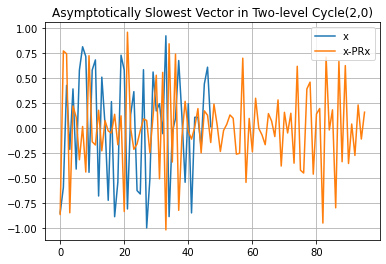

In [35]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [36]:
m1[1].a

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [37]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.001 -0.005 -0.005 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]
1 lam [-0.001 -0.005 -0.005 -0.018 -0.018 -0.038 -0.038 -0.063 -0.063 -0.091 -0.091 -0.106]


## 3-Level Method

In [38]:
m0.add(m1[1])

INFO         0 |r| 2.072e+01 RER 3.55724
INFO         1 |r| 1.300e-01 (0.00628) RER 0.01075 (0.00302) 12.101
INFO         2 |r| 4.901e-03 (0.03769) RER 0.00041 (0.03816) 11.952
INFO         3 |r| 4.028e-04 (0.08219) RER 0.00003 (0.08222) 11.946
INFO         4 |r| 4.013e-05 (0.09964) RER 0.00000 (0.09964) 11.946
INFO         5 |r| 4.181e-06 (0.10419) RER 0.00000 (0.10419) 11.946
INFO         6 |r| 4.452e-07 (0.10646) RER 0.00000 (0.10646) 11.946
INFO         7 |r| 4.808e-08 (0.10799) RER 0.00000 (0.10799) 11.946
INFO         8 |r| 5.238e-09 (0.10896) RER 0.00000 (0.10896) 11.946
INFO         9 |r| 5.748e-10 (0.10973) RER 0.00000 (0.10973) 11.946
INFO        10 |r| 6.340e-11 (0.11031) RER 0.00000 (0.11031) 11.946


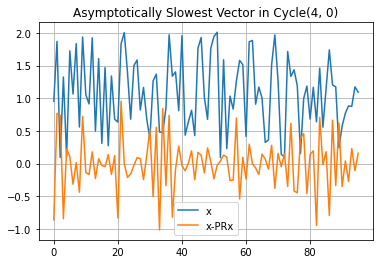

In [39]:
nu_pre = 4
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [40]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.004 -0.004 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]
1 lam [-0.001 -0.005 -0.005 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]
2 lam [-0.001 -0.005 -0.005 -0.018 -0.018 -0.038 -0.038 -0.063 -0.063 -0.091 -0.091 -0.106]


In [41]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

In [42]:
pd.DataFrame(m1[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,-0.0740,-0.0086,0.0381,0.0472,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0117,-0.1889,-0.0298,-0.0359,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0353,-0.0279,-0.0740,-0.0086,0.0381,0.0472,0.0000,0.0000,0.0000,0.0000
3,0.0420,-0.0306,-0.0117,-0.1889,-0.0298,-0.0359,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0353,-0.0279,-0.0740,-0.0086,0.0381,0.0472,0.0000,0.0000
5,0.0000,0.0000,0.0420,-0.0306,-0.0117,-0.1889,-0.0298,-0.0359,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0353,-0.0279,-0.0740,-0.0086,0.0381,0.0472
7,0.0000,0.0000,0.0000,0.0000,0.0420,-0.0306,-0.0117,-0.1889,-0.0298,-0.0359
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0353,-0.0279,-0.0740,-0.0086
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0420,-0.0306,-0.0117,-0.1889


In [43]:
pd.DataFrame((m1[1].a - m1[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0031,0.0028,0.0052,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0031,0.0000,-0.0018,-0.0053,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0028,0.0018,0.0000,0.0031,0.0028,0.0052,0.0000,0.0000,0.0000,0.0000
3,-0.0052,0.0053,-0.0031,0.0000,-0.0018,-0.0053,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0028,0.0018,0.0000,0.0031,0.0028,0.0052,0.0000,0.0000
5,0.0000,0.0000,-0.0052,0.0053,-0.0031,0.0000,-0.0018,-0.0053,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0028,0.0018,0.0000,0.0031,0.0028,0.0052
7,0.0000,0.0000,0.0000,0.0000,-0.0052,0.0053,-0.0031,0.0000,-0.0018,-0.0053
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0028,0.0018,0.0000,0.0031
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0052,0.0053,-0.0031,0.0000
